In [0]:
!pip install kaggle


In [0]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedelgamiel1","key":"50f42dd89f3519a96a2e9eff6fdaf5ee"}'}

In [0]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c state-farm-distracted-driver-detection

  0% 0.00/193k [00:00<?, ?B/s]
100% 193k/193k [00:00<00:00, 60.0MB/s]
100% 3.99G/4.00G [00:31<00:00, 134MB/s]
100% 4.00G/4.00G [00:31<00:00, 136MB/s]
  0% 0.00/92.9k [00:00<?, ?B/s]
100% 92.9k/92.9k [00:00<00:00, 102MB/s]


In [0]:
from zipfile import ZipFile
file_name = "driver_imgs_list.csv.zip"
with ZipFile(file_name , 'r') as zip :
    zip.extractall()
    print("Done")

Done


In [0]:
from zipfile import ZipFile
file_name = "imgs.zip"
with ZipFile(file_name , 'r') as zip :
    zip.extractall()
    print("Done")

Done


In [0]:
from zipfile import ZipFile
file_name = "sample_submission.csv.zip"
with ZipFile(file_name , 'r') as zip :
    zip.extractall()
    print("Done")

Done


In [0]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  

from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
import math
import pickle
import os
import matplotlib.image as mpimg

%matplotlib inline 

def load_dataset(path):
    data = load_files(path)
    driver_files = np.array(data['filenames'])
    driver_targets = np_utils.to_categorical(np.array(data['target']), 10)
    return driver_files, driver_targets

Using TensorFlow backend.


In [0]:
import pandas as pd 
df = pd.read_csv("driver_imgs_list.csv")
df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [0]:
import pandas as pd 
df = pd.read_csv("sample_submission.csv")
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [0]:
import pandas as pd 
df = pd.read_csv("sample_submission.csv")
df.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [0]:
train_files,train_targets = load_dataset('/content/train/')
test_files, test_targets = load_dataset('/content/test')


In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_files,train_targets ,test_size=0.3,random_state=42)

In [0]:
print('training targets size %d' % len(X_train))
print('test targets size %d' % len(X_test))


training targets size 15696
test targets size 6728


/content/train/c0/img_34878.jpg


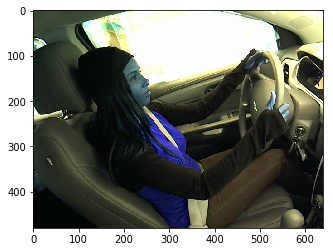

In [0]:
path=X_train[1]
print(path)
im = cv2.imread(path)
#cv2.imshow(im)
plt.imshow(im)
plt.show()

In [0]:
def resize_image(img_path):
    img = cv2.imread(img_path)
    return cv2.resize(img, (224, 224))

In [0]:
driver_resized = [resize_image(i) for i in train_files]


In [0]:
print("dogs dataset resize done! Size: %d." % len(driver_resized))

dogs dataset resize done! Size: 22424.


In [0]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [0]:
def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

##**Now we will create a CNN from scratch , then we will use transfer learning and compare results.**



###*Pre-process the Data*



In [0]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_targets=y_train
test_targets=y_test
train_tensors = paths_to_tensor(X_train).astype('float32')/255
test_tensors = paths_to_tensor(X_test).astype('float32')/255

100%|██████████| 6728/6728 [00:49<00:00, 135.87it/s]


In [0]:

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=2 , padding='same'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2  , padding='same'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2 , padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)           

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:

checkpointer = ModelCheckpoint(filepath='/content/weight.txt', verbose=1, save_best_only=True)

In [0]:
history=model.fit(train_tensors, train_targets, validation_split=0.2,epochs=5, batch_size=20, callbacks=[checkpointer], verbose=1)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 12556 samples, validate on 3140 samples
Epoch 1/5
12556/12556 [==============================] - 246s 20ms/step - loss: 2.3031 - acc: 0.1027 - val_loss: 2.3003 - val_acc: 0.1111

Epoch 00001: val_loss improved from inf to 2.30026, saving model to /content/weight.txt
Epoch 2/5
12556/12556 [==============================] - 246s 20ms/step - loss: 2.3016 - acc: 0.1121 - val_loss: 2.3038 - val_acc: 0.1006

Epoch 00002: val_loss did not improve from 2.30026
Epoch 3/5
12556/12556 [==============================] - 245s 20ms/step - loss: 2.2974 - acc: 0.1205 - val_loss: 2.2825 - val_acc: 0.1255

Epoch 00003: val_loss improved from 2.30026 to 2.28248, saving model to /content/weight.txt
Epoch 4/5
12556/12556 [==============================] - 247s 20ms/step - loss: 2.2851 - acc: 0.1309 - val_loss: 2.2655 - val_acc: 0.1436

Epoch 00004: val_loss improved from 2.28248 to 2.26545, saving model 

In [0]:
model.load_weights('/content/weight.txt')

In [0]:
driver_accuracy = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(driver_accuracy)==np.argmax(test_targets, axis=1))/len(driver_accuracy)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 16.9441%


In [0]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=train_tensors.shape[1:]))
model.add(MaxPooling2D(pool_size=2 , padding='same'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2  , padding='same'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2 , padding='same'))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2 , padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 128)      

In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weight2.txt', 
                               verbose=1, save_best_only=True)

In [0]:
history=model.fit(train_tensors, train_targets, validation_split=0.2,epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 12556 samples, validate on 3140 samples
Epoch 1/10
12556/12556 [==============================] - 30s 2ms/step - loss: 1.5021 - acc: 0.4032 - val_loss: 1.3186 - val_acc: 0.4656

Epoch 00001: val_loss improved from inf to 1.31858, saving model to /content/weight2.txt
Epoch 2/10
12556/12556 [==============================] - 29s 2ms/step - loss: 1.3494 - acc: 0.4739 - val_loss: 1.1706 - val_acc: 0.5519

Epoch 00002: val_loss improved from 1.31858 to 1.17064, saving model to /content/weight2.txt
Epoch 3/10
12556/12556 [==============================] - 29s 2ms/step - loss: 1.1775 - acc: 0.5561 - val_loss: 1.0550 - val_acc: 0.6051

Epoch 00003: val_loss improved from 1.17064 to 1.05500, saving model to /content/weight2.txt
Epoch 4/10
12556/12556 [==============================] - 29s 2ms/step - loss: 1.0196 - acc: 0.6254 - val_loss: 0.9437 - val_acc: 0.6395

Epoch 00004: val_loss improved from 1.05500 to 0.94372, saving model to /content/weight2.txt
Epoch 5/10
12556/12556 [=======

In [0]:
model.load_weights('/content/weight2.txt')

driver_accuracy = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(driver_accuracy)==np.argmax(test_targets, axis=1))/len(driver_accuracy)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 89.7295%


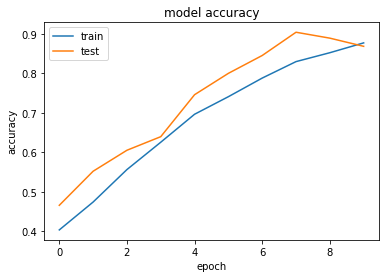

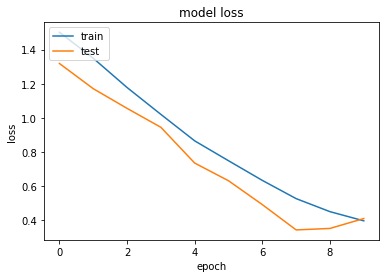

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
import keras
vgg16_model = keras.applications.vgg16.VGG16()

In [0]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [0]:
model_VGG_3 = Sequential()
i = 0
for layer in vgg16_model.layers :
    if (i == len(vgg16_model.layers)-3) :
        break
    model_VGG_3.add(layer)
    i += 1

In [0]:
model_VGG_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [0]:
for layer in model_VGG_3.layers :
    layer.trainable = False

In [0]:
model_VGG_3.add(Dense(400 , activation = 'relu'))
model.add(Dropout(0.2))

In [0]:
model_VGG_3.add(Dense(40 , activation = 'relu'))
model.add(Dropout(0.2))

In [0]:
model_VGG_3.add(Dense(10 , activation = 'softmax'))

In [0]:
model_VGG_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [0]:
from keras import optimizers
from keras.optimizers import Adam
model_VGG_3.compile(Adam(lr=0.0001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath='/content/weight2.txt', verbose=1, save_best_only=True)
model_VGG_3.fit(train_tensors, train_targets, validation_split=0.2,epochs=5, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 12556 samples, validate on 3140 samples
Epoch 1/5
12556/12556 [==============================] - 189s 15ms/step - loss: 0.4902 - acc: 0.8809 - val_loss: 0.0927 - val_acc: 0.9879

Epoch 00001: val_loss improved from inf to 0.09271, saving model to /content/weight2.txt
Epoch 2/5
12556/12556 [==============================] - 187s 15ms/step - loss: 0.0508 - acc: 0.9923 - val_loss: 0.0590 - val_acc: 0.9876

Epoch 00002: val_loss improved from 0.09271 to 0.05896, saving model to /content/weight2.txt
Epoch 3/5
12556/12556 [==============================] - 187s 15ms/step - loss: 0.0208 - acc: 0.9968 - val_loss: 0.0194 - val_acc: 0.9962

Epoch 00003: val_loss improved from 0.05896 to 0.01940, saving model to /content/weight2.txt
Epoch 4/5
12556/12556 [==============================] - 187s 15ms/step - loss: 0.0089 - acc: 0.9992 - val_loss: 0.0204 - val_acc: 0.9939

Epoch 00004: val_loss did not improve from 0.01940
Epoch 5/5
12556/12556 [==============================] - 187s 15ms/st

In [0]:
model_VGG_3.load_weights('/content/weight2.txt')
driver_accuracy = [np.argmax(model_VGG_3.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(driver_accuracy)==np.argmax(test_targets, axis=1))/len(driver_accuracy)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 99.5392%


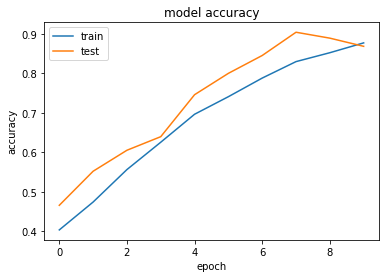

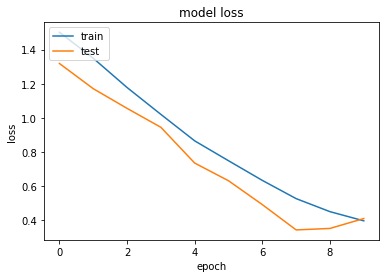

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()